In [1]:
import tsai.all
import datetime
import pandas as pd
import torch
import numpy as np
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import time
import math

In [2]:
%run ../../shared_functions.py
%run ../../my_shared_functions.py

<Figure size 640x480 with 0 Axes>

In [3]:
DIR_INPUT = '../../../fraud-detection-handbook/simulated-data-transformed/data/'

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

BEGIN_DATE = "2018-08-08"
start_date_training = datetime.datetime.strptime(BEGIN_DATE, "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7

delta_valid = delta_test

(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

SEQ_LEN = 5
SEED = 42

if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

seed_everything(SEED)

(train_df, valid_df)=scaleData(train_df, valid_df,input_features)
x_train, y_train = prepare_sequenced_X_y(train_df, SEQ_LEN, input_features, output_feature)
x_valid, y_valid = prepare_sequenced_X_y(valid_df, SEQ_LEN, input_features, output_feature)
X, y, splits = tsai.all.combine_split_data([x_train.numpy(), x_valid.numpy()], [y_train.numpy(), y_valid.numpy()])

Load  files
CPU times: total: 609 ms
Wall time: 5.14 s
919767 transactions loaded, containing 8195 fraudulent transactions
Selected device is cuda


### OmniScaleCNN

Hyperparameters from youthful-sweep-4

In [7]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=128,
    num_workers=0,
    few_shot=False,
    layers=[8*128, 5 * 128 * 256 + 2 * 256  *128],
    early_stopping=False,
    max_epochs=8,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['omniscalecnn', 'tsai', 'imbalance-not-considered', 'hypertuned'])
config = wandb.config

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.032693,0.024403,00:18
1,0.022330,0.019872,00:18
2,0.019511,0.020546,00:18
3,0.031734,0.019775,00:19
4,0.021480,0.019280,00:20
5,0.013826,0.019721,00:20
6,0.024757,0.019556,00:20
7,0.012727,0.019181,00:20


Better model found at epoch 0 with valid_loss value: 0.024402886629104614.
Better model found at epoch 1 with valid_loss value: 0.019871512427926064.
Better model found at epoch 3 with valid_loss value: 0.01977452076971531.
Better model found at epoch 4 with valid_loss value: 0.019280491396784782.
Better model found at epoch 7 with valid_loss value: 0.01918097771704197.


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,▄▂▁▃█▃▆▁▁▁▁▁▁▁▁▁▁▁▄▁▄▁▁▁▁▁▁▂▁▁▁▃▃▁▁▄▁▁▂▁


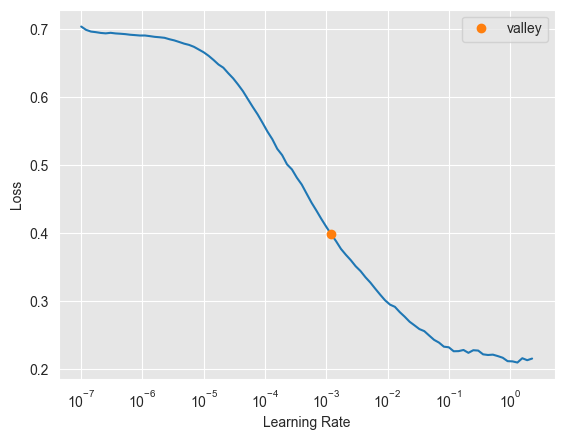

In [8]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.OmniScaleCNN(
    c_in=dls.vars, 
    c_out=dls.c,
    seq_len=SEQ_LEN,
    layers=config.layers,
    few_shot=config.few_shot
    )

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='OmniScaleCNN',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        SaveModelCallback(
            fname='omniscalecnn_ht_fit_one_cycle'
        )])

lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

### ResNet

Hyperparameters from magic-sweep-7

In [9]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=64,
    num_workers=0,
    early_stopping=False,
    max_epochs=7,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['resnet', 'tsai', 'imbalance-not-considered', 'hypertuned'])
config = wandb.config

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.027672,0.024380,00:36
1,0.023965,0.020253,00:32
2,0.019866,0.019888,00:32
3,0.016480,0.026859,00:31
4,0.018198,0.019375,00:31
5,0.009359,0.019534,00:31
6,0.012099,0.019889,00:33


Better model found at epoch 0 with valid_loss value: 0.024380316957831383.
Better model found at epoch 1 with valid_loss value: 0.020252780988812447.
Better model found at epoch 2 with valid_loss value: 0.019888238981366158.
Better model found at epoch 4 with valid_loss value: 0.019375069066882133.


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▃▂▁▁▁▁▃▁▁▁▁▁▁▁▁▁▃▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


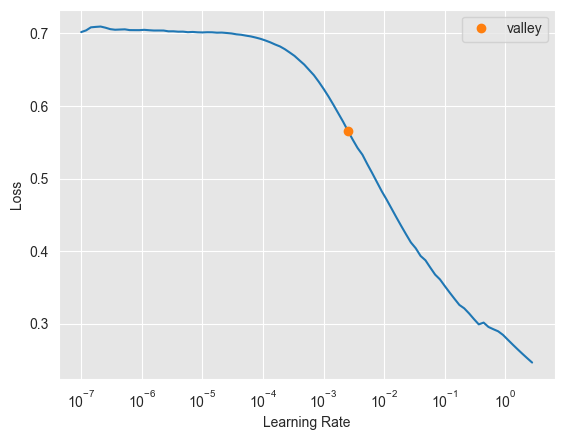

In [10]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.ResNet(
    c_in=dls.vars, 
    c_out=dls.c)

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='ResNet',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        SaveModelCallback(
            fname='resnet_ht_fit_one_cycle'
        )])

lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

### FCN

Hyperparameters from revived-sweep-37

In [8]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=256,
    num_workers=0,
    layers=[64, 128, 64],
    kss=[7, 5 ,3],
    max_epochs=7,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['fcn', 'tsai', 'imbalance-not-considered', 'hypertuned'])
config = wandb.config

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.084527,0.039880,00:03
1,0.021159,0.020939,00:03
2,0.025877,0.020846,00:03
3,0.021411,0.019147,00:03
4,0.015639,0.019728,00:03
5,0.032260,0.020297,00:03
6,0.011953,0.019490,00:03


Better model found at epoch 0 with valid_loss value: 0.039879877120256424.
Better model found at epoch 1 with valid_loss value: 0.020938733592629433.
Better model found at epoch 2 with valid_loss value: 0.02084631286561489.
Better model found at epoch 3 with valid_loss value: 0.01914730668067932.


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▅▄▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁


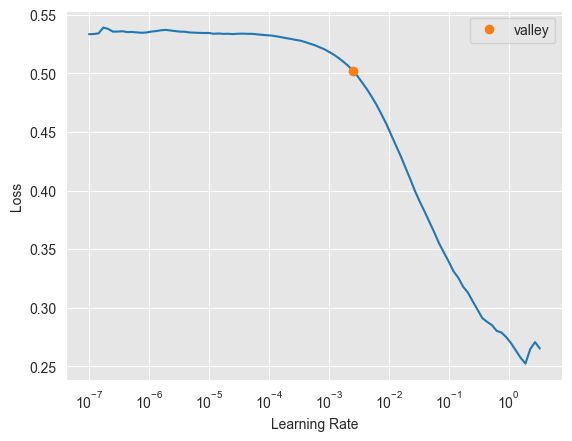

In [9]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.FCN(
    c_in=dls.vars, 
    c_out=dls.c,
    layers=config.layers,
    kss=config.kss
    )

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='FCN',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        SaveModelCallback(
            fname='fcn_ht_fit_one_cycle'
        )])

lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

### gMLP

hyperparameters from colorful-sweep-44

In [10]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=64,
    num_workers=0,
    seq_len=SEQ_LEN,
    patch_size=1,
    d_model=128,
    d_ffn=256,
    depth=7,
    optimizer='adam',
    max_epochs=12,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['gMLP', 'tsai', 'imbalance-not-considered', 'hypertuned'])
config = wandb.config

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.038180,0.034400,00:45
1,0.023678,0.020796,00:46
2,0.018994,0.021682,00:47
3,0.018343,0.019080,00:48
4,0.024172,0.018333,00:48
5,0.015509,0.017244,00:46
6,0.017717,0.017180,00:50
7,0.012632,0.016711,00:47
8,0.013523,0.017240,00:48
9,0.013633,0.016823,00:48


Better model found at epoch 0 with valid_loss value: 0.03440021350979805.
Better model found at epoch 1 with valid_loss value: 0.020796025171875954.
Better model found at epoch 3 with valid_loss value: 0.01908017136156559.
Better model found at epoch 4 with valid_loss value: 0.018332533538341522.
Better model found at epoch 5 with valid_loss value: 0.017243940383195877.
Better model found at epoch 6 with valid_loss value: 0.017180364578962326.
Better model found at epoch 7 with valid_loss value: 0.01671060174703598.


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▆▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,▆▅▁▄▁▁▂▂▃▁▄▅▅▁▁▃▁▁▁▁▁▄▁▂▂▁▄▁▁▂▁▁▁▁▂▁▁█▁▁


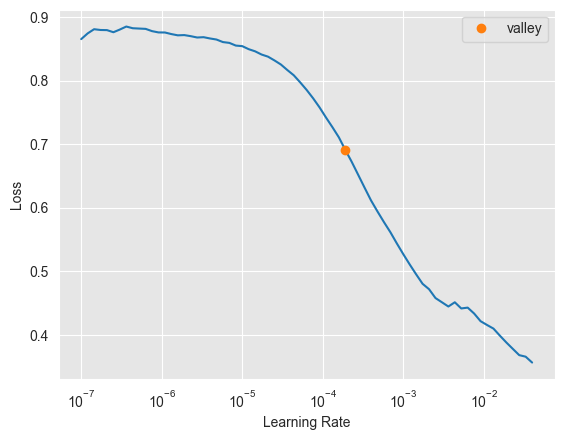

In [11]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.gMLP(
    dls.vars,
    dls.c,
    SEQ_LEN,
    patch_size=config.patch_size,
    d_model=config.d_model,
    d_ffn=config.d_ffn,
    depth=config.depth
    )

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='gMLP',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        SaveModelCallback(
            fname='gmlp_ht_fit_one_cycle'
        )])

# lr = 0.001
lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

In [7]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇██
mom_0,███████████▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
raw_loss,█▇▆▅▄▃▃▂▃▂▂▂▁▁▂▁▁▁▁▂▁▁▁▂▂▁▂▁▁▂▂▁▁▁▁▁▁▂▁▂
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_samples_per_sec,▃▆▇▇▁▅▇▁▇▄▇▆▇▆▅▇█▇▇▇▇▅▄▆█▆▄▆▆█▆▇▆▅▄▆▆▄▆▄
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,0.44995
eps_0,1e-05


### GRU-FCN

hyperparameters from autumn-sweep-21

In [12]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=64,
    num_workers=0,
    seq_len=SEQ_LEN,
    hidden_size = 100,
    rnn_layers = 2,
    bias=True,
    rnn_dropout=0.4,
    cell_dropout=0.2,
    conv_layers=[64, 128, 64],
    kss=[5, 5, 3],
    bidirectional=False,
    fc_dropout=0.2,
    se=0,
    optimizer='adam',
    max_epochs=5,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['gru-fcn', 'tsai', 'imbalance-not-considered', 'hypertuned'])
config = wandb.config

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.021313,0.029405,00:21
1,0.022012,0.024450,00:19
2,0.020449,0.020613,00:19
3,0.016480,0.020214,00:19
4,0.017398,0.020377,00:19


Better model found at epoch 0 with valid_loss value: 0.029404763132333755.
Better model found at epoch 1 with valid_loss value: 0.024450235068798065.
Better model found at epoch 2 with valid_loss value: 0.020613063126802444.
Better model found at epoch 3 with valid_loss value: 0.020214177668094635.


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇████████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▃▃▂▁▁▂▂▁▁▃▁▁▁▁▁▁▁▁▂▁▃▁▁▁▁▃▁▁▁▁▁▁▁▁▁▃▁▁▁


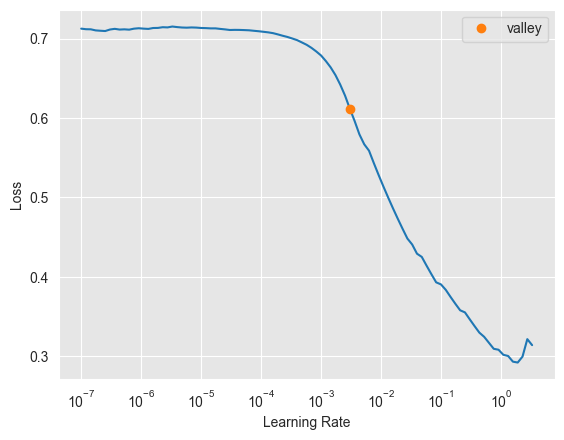

In [13]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.GRU_FCN(
    c_in=dls.vars, 
    c_out=dls.c,
    seq_len=SEQ_LEN,
    hidden_size=config.hidden_size,
    rnn_layers=config.rnn_layers,
    bias=config.bias,
    cell_dropout=config.cell_dropout,
    rnn_dropout=config.rnn_dropout,
    bidirectional=config.bidirectional,
    fc_dropout=config.fc_dropout,
    conv_layers=config.conv_layers,
    kss=config.kss,
    se=config.se
    )

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='GRU_FCN',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        SaveModelCallback(
            fname='gru_fcn_ht_fit_one_cycle'
        )])

# lr = 0.001
lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

### GRU

hyperparameters from decent-sweep-54

In [14]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=64,
    num_workers=0,
    seq_len=SEQ_LEN,
    hidden_size = 100,
    n_layers = 2,
    rnn_dropout=0.2,
    bidirectional=False,
    fc_dropout=0.4,
    optimizer='adam',
    max_epochs=5,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['gru', 'tsai', 'imbalance-not-considered', 'hypertuned'])
config = wandb.config

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.028556,0.022240,00:12
1,0.025978,0.021700,00:13
2,0.022175,0.018703,00:12
3,0.015526,0.018537,00:12
4,0.017012,0.017831,00:12


Better model found at epoch 0 with valid_loss value: 0.022240132093429565.
Better model found at epoch 1 with valid_loss value: 0.021700136363506317.
Better model found at epoch 2 with valid_loss value: 0.018702857196331024.
Better model found at epoch 3 with valid_loss value: 0.018537260591983795.
Better model found at epoch 4 with valid_loss value: 0.01783119887113571.


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇████████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▁▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▃▁▁▃▁▁▁▁▃▁▁▁▁


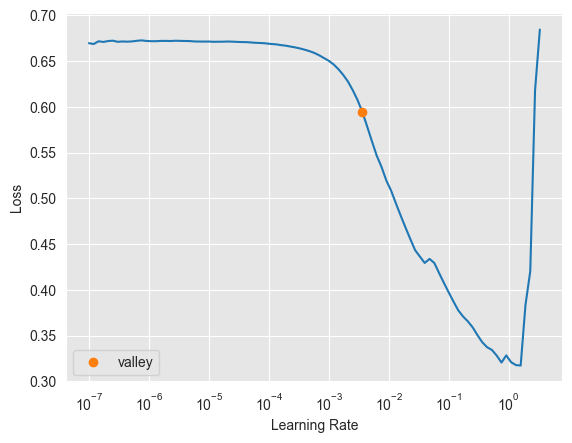

In [15]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.GRU(
                c_in=dls.vars,
                c_out=dls.c,
                hidden_size=config.hidden_size,
                n_layers=config.n_layers,
                rnn_dropout=config.rnn_dropout,
                fc_dropout=config.fc_dropout)

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='GRU',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        SaveModelCallback(
            fname='gru_ht_fit_one_cycle'
        )])

lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

### InceptionTime
hyperparameters from deep-sweep-9

In [16]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=128,
    num_workers=0,
    seq_len=SEQ_LEN,
    nf=64,
    nb_filters=None,
    optimizer='adam',
    max_epochs=5,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['inceptiontime', 'tsai', 'imbalance-not-considered', 'hypertuned'])
config = wandb.config

wandb: 409 encountered ({"errors":[{"message":"Error 1062 (23000): Duplicate entry '37181889-991zd8al' for key 'PRIMARY'","path":["upsertBucket"]}],"data":{"upsertBucket":null}}), retrying request
wandb: Network error resolved after 0:00:31.657231, resuming normal operation.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.027948,0.035211,00:24
1,0.026225,0.025158,00:27
2,0.022914,0.022291,00:26
3,0.018377,0.019702,00:27
4,0.013383,0.018863,00:27


Better model found at epoch 0 with valid_loss value: 0.035210609436035156.
Better model found at epoch 1 with valid_loss value: 0.025158245116472244.
Better model found at epoch 2 with valid_loss value: 0.022291334345936775.
Better model found at epoch 3 with valid_loss value: 0.01970209926366806.
Better model found at epoch 4 with valid_loss value: 0.018862584605813026.


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇█████
raw_loss,█▃▂▁▁▂▅▂▁▁▂▁▁▁▁▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂


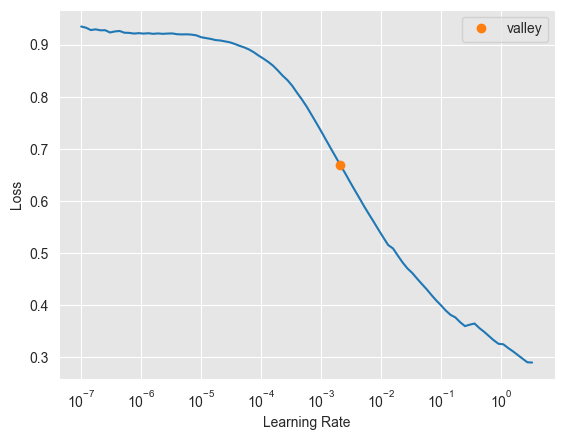

In [17]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.InceptionTime(
    c_in=dls.vars,
    c_out=dls.c,
    nf=config.nf,
    nb_filters=config.nb_filters)

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='InceptionTime',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        SaveModelCallback(
            fname='inceptiontime_ht_fit_one_cycle'
        )])

lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

### LSTM-FCN
hyperparameters from lyric-sweep-56

In [18]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=64,
    num_workers=0,
    seq_len=SEQ_LEN,
    hidden_size = 100,
    rnn_layers = 2,
    bias=True,
    rnn_dropout=0,
    cell_dropout=0.2,
    conv_layers=[64, 128, 64],
    kss=[5, 5, 3],
    bidirectional=False,
    fc_dropout=0.2,
    se=0, # squeeze-and-excite, which equals to 16 for MLSTM-FCN
    optimizer='adam',
    max_epochs=5,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['lstm-fcn', 'tsai', 'imbalance-not-considered', 'hypertuned'])
config = wandb.config

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.031787,0.026349,00:21
1,0.019219,0.021834,00:22
2,0.019172,0.020790,00:21
3,0.020824,0.020229,00:20
4,0.014801,0.019664,00:21


Better model found at epoch 0 with valid_loss value: 0.026349462568759918.
Better model found at epoch 1 with valid_loss value: 0.0218336284160614.
Better model found at epoch 2 with valid_loss value: 0.020789531990885735.
Better model found at epoch 3 with valid_loss value: 0.020229056477546692.
Better model found at epoch 4 with valid_loss value: 0.019664283841848373.


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇████████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁


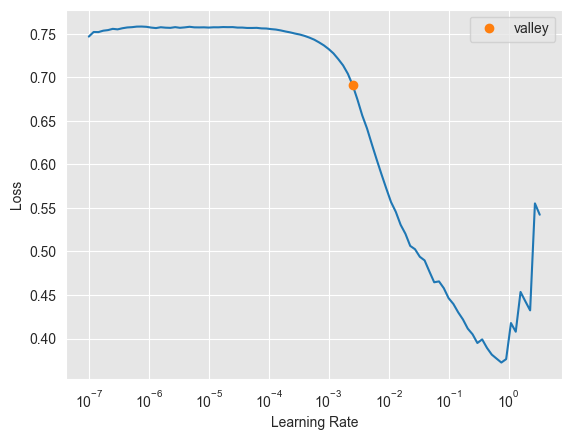

In [19]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.LSTM_FCN(
                c_in=dls.vars, 
                c_out=dls.c,
                seq_len=SEQ_LEN,
                hidden_size=config.hidden_size,
                rnn_layers=config.rnn_layers,
                bias=config.bias,
                cell_dropout=config.cell_dropout,
                rnn_dropout=config.rnn_dropout,
                bidirectional=config.bidirectional,
                fc_dropout=config.fc_dropout,
                conv_layers=config.conv_layers,
                kss=config.kss,
                se=config.se
                )

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='LSTM_FCN',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        SaveModelCallback(
            fname='lstm_fcn_ht_fit_one_cycle'
        )])

lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

### LSTM
hyperparameters from mild-sweep-55

In [20]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=128,
    num_workers=0,
    seq_len=SEQ_LEN,
    hidden_size = 100,
    n_layers = 2,
    rnn_dropout=0,
    bidirectional=False,
    fc_dropout=0,
    optimizer='adam',
    max_epochs=10,
    scale=True,
    criterion='bce',
    one_cycle_policy=False
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['lstm', 'tsai', 'imbalance-not-considered', 'hypertuned'])
config = wandb.config

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.039163,0.030608,00:06
1,0.027134,0.021948,00:06
2,0.024874,0.020796,00:06
3,0.019442,0.019634,00:06
4,0.021051,0.018025,00:06
5,0.016038,0.018055,00:07
6,0.017206,0.017476,00:07
7,0.012033,0.017241,00:06
8,0.016270,0.017429,00:06
9,0.014062,0.017463,00:06


Better model found at epoch 0 with valid_loss value: 0.030608180910348892.
Better model found at epoch 1 with valid_loss value: 0.02194836735725403.
Better model found at epoch 2 with valid_loss value: 0.02079561911523342.
Better model found at epoch 3 with valid_loss value: 0.019633589312434196.
Better model found at epoch 4 with valid_loss value: 0.018025299534201622.
Better model found at epoch 6 with valid_loss value: 0.017475880682468414.
Better model found at epoch 7 with valid_loss value: 0.017241373658180237.


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇█████
raw_loss,█▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▂▁▁▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▂


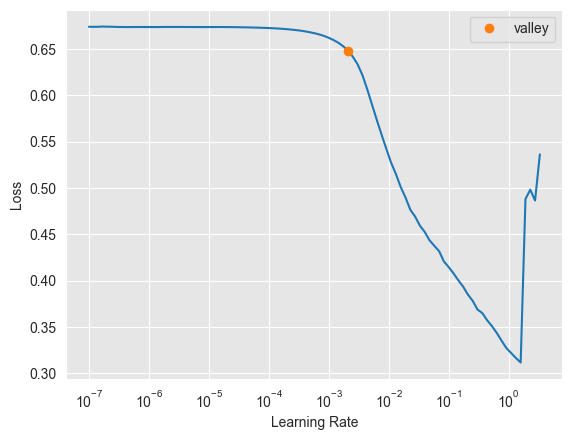

In [21]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.LSTM(
                c_in=dls.vars,
                c_out=dls.c,
                hidden_size=config.hidden_size,
                n_layers=config.n_layers,
                rnn_dropout=config.rnn_dropout,
                fc_dropout=config.fc_dropout)

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='LSTM',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        SaveModelCallback(
            fname='lstm_ht_fit_one_cycle'
        )])

lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

### MLSTM-FCN
hyperparameters from avid-sweep-49

In [22]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=128,
    num_workers=0,
    seq_len=SEQ_LEN,
    hidden_size = 100,
    rnn_layers = 1,
    bias=True,
    rnn_dropout=0.4,
    cell_dropout=0.2,
    conv_layers=[64, 256, 64],
    kss=[5, 3, 1],
    bidirectional=False,
    fc_dropout=0.2,
    se=16, # squeeze-and-excite
    optimizer='adam',
    max_epochs=5,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['mlstm-fcn', 'tsai', 'imbalance-not-considered', 'hypertuned'])
config = wandb.config

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.027982,0.023776,00:11
1,0.023357,0.021623,00:11
2,0.024841,0.020161,00:11
3,0.016044,0.019127,00:12
4,0.014141,0.018805,00:12


Better model found at epoch 0 with valid_loss value: 0.023775938898324966.
Better model found at epoch 1 with valid_loss value: 0.02162284590303898.
Better model found at epoch 2 with valid_loss value: 0.020160606130957603.
Better model found at epoch 3 with valid_loss value: 0.01912694424390793.
Better model found at epoch 4 with valid_loss value: 0.01880522444844246.


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇█████
raw_loss,█▄▁▁▂▁▁▁▁▁▁▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁


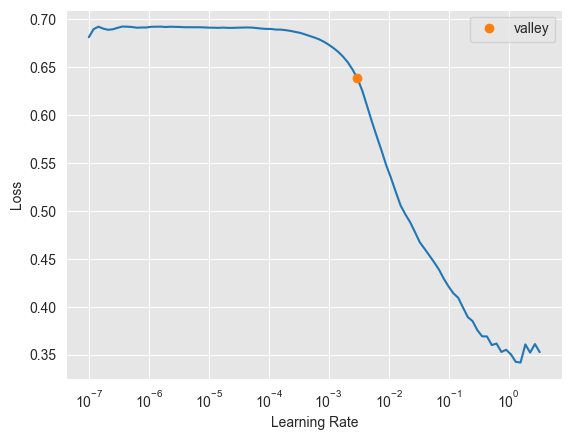

In [23]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.MLSTM_FCN(
    c_in=dls.vars, 
    c_out=dls.c,
    seq_len=SEQ_LEN,
    hidden_size=config.hidden_size,
    rnn_layers=config.rnn_layers,
    bias=config.bias,
    cell_dropout=config.cell_dropout,
    rnn_dropout=config.rnn_dropout,
    bidirectional=config.bidirectional,
    fc_dropout=config.fc_dropout,
    conv_layers=config.conv_layers,
    kss=config.kss,
    se=config.se
    )

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='MLSTM_LSTM',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        SaveModelCallback(
            fname='mlstm_fcn_ht_fit_one_cycle'
        )])

lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

### ResCNN
hyperparameters from pleasant-sweep-28

In [24]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=128,
    num_workers=0,
    seq_len=SEQ_LEN,
    coord=False,
    separable=False,
    zero_norm=False,
    max_epochs=9,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['rescnn', 'tsai', 'imbalance-not-considered', 'hypertuned'])
config = wandb.config

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.029398,0.021504,00:11
1,0.029504,0.022405,00:11
2,0.022806,0.020109,00:11
3,0.018612,0.019809,00:11
4,0.017450,0.018880,00:12
5,0.012155,0.019085,00:12
6,0.012154,0.020226,00:11
7,0.009655,0.021541,00:12
8,0.007796,0.022060,00:12


Better model found at epoch 0 with valid_loss value: 0.021503757685422897.
Better model found at epoch 2 with valid_loss value: 0.020109068602323532.
Better model found at epoch 3 with valid_loss value: 0.01980937086045742.
Better model found at epoch 4 with valid_loss value: 0.018880436196923256.


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇▇███████▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▁▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▆▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▂▂▁▁▁▁▁▂▁▁▂▂▁▃▁▁▁▂▁▁▁▁▁


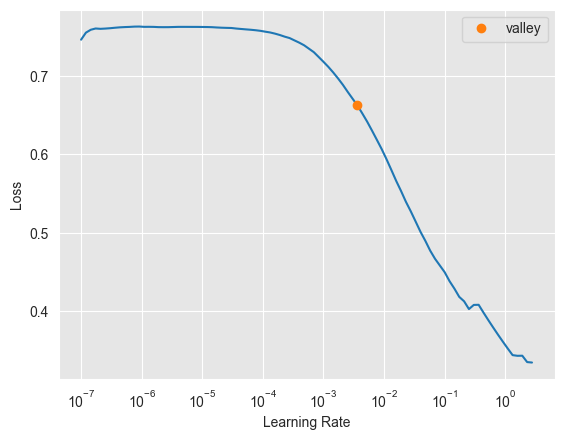

In [25]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.ResCNN(
                c_in=dls.vars, 
                c_out=dls.c,
                coord=config.coord,
                separable=config.separable,
                zero_norm=config.zero_norm
            )

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='ResCNN',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        SaveModelCallback(
            fname='rescnn_ht_fit_one_cycle'
        )])

lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

### TSiT
hyperparameters from vibrant-sweep-57

In [4]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=64,
    num_workers=0,
    seq_len=SEQ_LEN,
    d_model=32,
    depth=5,
    n_heads=16,
    act='gelu',
    lsa=False,
    attn_dropout=0.3,
    dropout=0,
    drop_path_rate=0,
    mlp_ratio=1,
    qkv_bias=True,
    pre_norm=True,
    use_token=False, # use_token set to False as c_out == 1
    use_pe=True,
    cat_pos=None,
    n_cat_embeds=None,
    cat_embed_dims=None,
    cat_padding_idxs=None,
    token_size=None,
    tokenizer=None,
    feature_extractor=None,
    flatten=False,
    concat_pool=True,
    fc_dropout=0.1,
    use_bn=False,
    bias_init=None,
    y_range=None,
    custom_head=None,
    optimizer='adam',
    max_epochs=5,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['tsit', 'transformer', 'tsai', 'imbalance-not-considered', 'hypertuned'])
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chamera (mgr-anomaly-tsxai). Use `wandb login --relogin` to force relogin


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.034451,0.027080,00:54
1,0.020899,0.018656,01:04
2,0.017521,0.018600,01:01
3,0.016742,0.017008,01:00
4,0.018763,0.016944,01:01


Better model found at epoch 0 with valid_loss value: 0.02707967907190323.
Better model found at epoch 1 with valid_loss value: 0.01865622028708458.
Better model found at epoch 2 with valid_loss value: 0.018600057810544968.
Better model found at epoch 3 with valid_loss value: 0.017008056864142418.
Better model found at epoch 4 with valid_loss value: 0.016943633556365967.


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇████████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇████████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁


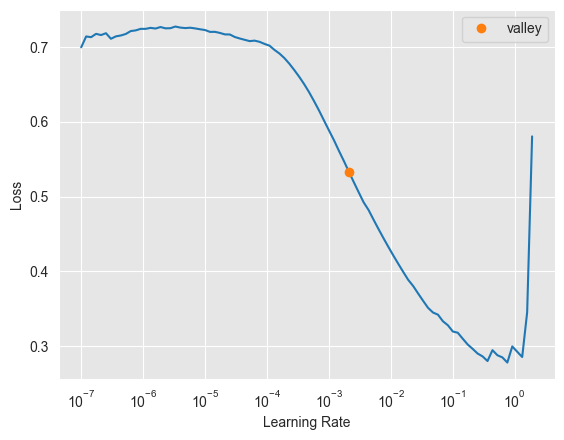

In [5]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.TSiT(
    c_in=dls.vars,
    c_out=dls.c,
    seq_len=SEQ_LEN,
    d_model=config.d_model,
    depth=config.depth,
    n_heads=config.n_heads,
    act=config.act,
    lsa=config.lsa,
    attn_dropout=config.attn_dropout,
    dropout=config.dropout,
    drop_path_rate=config.drop_path_rate,
    mlp_ratio=config.mlp_ratio,
    qkv_bias=config.qkv_bias,
    pre_norm=config.pre_norm,
    use_token=config.use_token,
    use_pe=config.use_pe,
    cat_pos=config.cat_pos,
    n_cat_embeds=config.n_cat_embeds,
    cat_embed_dims=config.cat_embed_dims,
    cat_padding_idxs=config.cat_padding_idxs,
    token_size=config.token_size,
    tokenizer=config.tokenizer,
    feature_extractor=config.feature_extractor,
    flatten=config.flatten,
    concat_pool=config.concat_pool,
    fc_dropout=config.fc_dropout,
    use_bn=config.use_bn,
    bias_init=config.bias_init,
    y_range=config.y_range,
    custom_head=config.custom_head
)

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='TSiT',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        SaveModelCallback(
            fname='tsit_ht_fit_one_cycle'
        )])

lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

### TST
hyperparameters from spring-sweep-39

In [28]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=256,
    num_workers=0,
    seq_len=SEQ_LEN,
    max_seq_len=None,
    n_layers=1,
    d_model=32,
    n_heads=16,
    d_k=None,
    d_v=None,
    d_ff=256,
    dropout=0.1,
    act='gelu',
    fc_dropout=0.,
    optimizer='adam',
    max_epochs=10,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['tst', 'transformer', 'tsai', 'imbalance-not-considered', 'hypertuned'])
config = wandb.config

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.069013,0.029233,00:05
1,0.024439,0.021993,00:04
2,0.022765,0.020390,00:04
3,0.021177,0.019015,00:05
4,0.017469,0.020271,00:05
5,0.031946,0.019117,00:05
6,0.018530,0.019421,00:05
7,0.017856,0.018341,00:05
8,0.016297,0.018132,00:05
9,0.016950,0.018091,00:05


Better model found at epoch 0 with valid_loss value: 0.029232505708932877.
Better model found at epoch 1 with valid_loss value: 0.021992914378643036.
Better model found at epoch 2 with valid_loss value: 0.02039002813398838.
Better model found at epoch 3 with valid_loss value: 0.019014615565538406.
Better model found at epoch 7 with valid_loss value: 0.01834082417190075.
Better model found at epoch 8 with valid_loss value: 0.01813214085996151.
Better model found at epoch 9 with valid_loss value: 0.018091345205903053.


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▅▂▂▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁


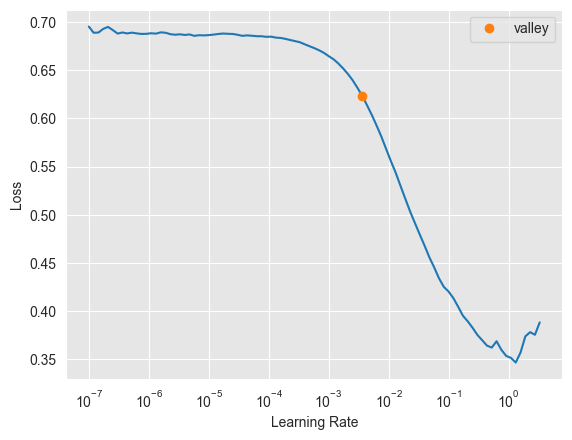

In [29]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.TST(
    c_in=dls.vars, 
    c_out=dls.c,
    seq_len=SEQ_LEN,
    n_layers=config.n_layers,
    d_model=config.d_model,
    n_heads=config.n_heads,
    d_k=config.d_k,
    d_v=config.d_v,
    d_ff=config.d_ff,
    dropout=config.dropout,
    act=config.act,
    fc_dropout=config.fc_dropout
    )

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='TST',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        SaveModelCallback(
            fname='tst_ht_fit_one_cycle'
        )])

lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

### XCM
hyperparameters from radiant-sweep-34

In [30]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=64,
    num_workers=0,
    window_perc=1,
    flatten=False,
    concat_pool=False,
    fc_dropout=0,
    bn=False,
    y_range=None,
    max_epochs=8,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['xcm', 'tsai', 'imbalance-not-considered', 'hypertuned'])
config = wandb.config

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.024220,0.022127,00:19
1,0.024138,0.023887,00:19
2,0.022172,0.023252,00:19
3,0.017865,0.020659,00:20
4,0.018792,0.019960,00:20
5,0.018498,0.019833,00:19
6,0.016146,0.019739,00:20
7,0.013138,0.019553,00:19


Better model found at epoch 0 with valid_loss value: 0.022127315402030945.
Better model found at epoch 3 with valid_loss value: 0.020659375935792923.
Better model found at epoch 4 with valid_loss value: 0.019959820434451103.
Better model found at epoch 5 with valid_loss value: 0.019833192229270935.
Better model found at epoch 6 with valid_loss value: 0.019739490002393723.
Better model found at epoch 7 with valid_loss value: 0.019553042948246002.


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,▆█▄▁▁▅▁▁▁▁▁▁▁▁▄▁▁▁▆▅▁▁▂▁▄▁▁▁█▃▅▁▄▁▃▁▁▁▁▁


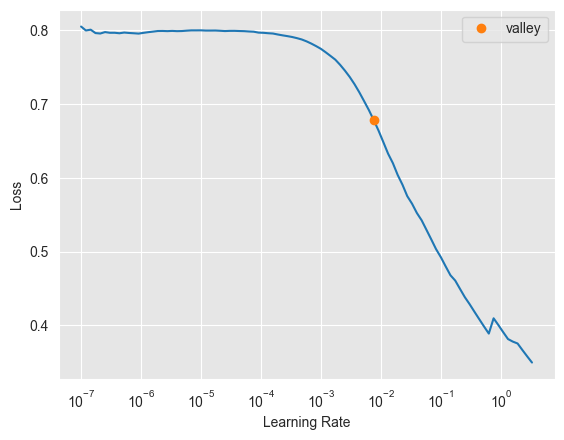

In [32]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.XCM(
    c_in=dls.vars, 
    c_out=dls.c,
    seq_len=SEQ_LEN,
    window_perc=config.window_perc, # window_size = int(round(seq_len * window_perc, 0))
                                    # ...Conv2d(1, nf, kernel_size=(1, window_size))...
    flatten=config.flatten,         # keep False if possible
    concat_pool=config.concat_pool, # True or False
    fc_dropout=config.fc_dropout,   # float range
    bn=config.bn,                   # True or False
    y_range=config.y_range          # None or tuple(low, high) where fastai.SigmoidRange(low, high)
    )

criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='XCM',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        SaveModelCallback(
            fname='xcm_ht_fit_one_cycle'
        )])

lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])

wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()